# <b> Final Project - Glassman Yair, Vanelli Martina </b>
<h2 style="color:#C40233"> <b> CS236605: Deep Learning </b> </h2>

## <b> Our project </b>

As anticipated, the aim of our project is to study the performance of the model and the successfulness of the adversarial attacks according to the graph structure.<br>
Our main problem was then to create realistic datasets with different graph structures to be tested with Nettack. 


<h3 style="color:#C40233"> <b> The original datasets </b> </h3>

We decided to start from the datasets analyzed in the article: `citeseer.npz` and `cora.npz`. They both contain information about papers. 

The Cora dataset contains machine-learning papers divided into one of 7 classes (Case Based, Genetic Algorithms, Neural Networks, Probabilistic Methods, Reinforcement Learning, Rule Learning, Theory) while the CiteSeer data set has 6 class labels (Agents, AI, DB, IR, ML, HCI). For both datasets, they performed stemming and stop word removal beside removing the words with document frequency less than 10. <br>
The final corpus has 2708 documents (nodes), 1433 distinct words in the vocabulary (node features) and 5429 links (graph structure) in the case of Cora; and 3312 documents, 3703 distinct words in the vocabulary and 4732 links in the case of CiteSeer.


<b> Note: </b> In the original datasets, the graphs are directed. Since the implemented model takes as input an indirected graph, the authors change the data structure at the beginning of the code by making every link undirected (either if $A$ cites $B$ or $B$ cites $A$ or they both cite each other, they simply register that there is a connection between $A$ and $B$). We decided to use the same approach. 

<h3 style="color:#C40233"> <b> The Stochastic Block Model and our new datasets</b> </h3>

For simplicity, we decided to create our datasets starting from the ones already used in the article. We decided to keep the features and the labels of the old datasets and to change the relationship among the nodes.

We used the random graphs theory to change the graph structure and to generate different graphs. <br> In particolar, we chose a specific random graph model: the <b>Stochastic Block Model</b>.
The stochastic block model takes the following parameters:
* The number $n$ of vertices;
* a partition of the vertex set $\{ 1 ,\dots , n \}$ into disjoint subsets $C_1 ,\dots , C_r$, called communities;
* a symmetric $r \times r$  matrix $P$ of edge probabilities.

The edge set is then sampled at random as follows: any two vertices $u \in C_i$ and $v \in C_j$ are connected by an edge independently with probability $P_{ij}$.

This model does not really fit the original dataset since the citations between articles are not independent from each other, but it is very useful for the scope of our project that is to study the importance of communities. The SBM produces indeed random graphs containing <b>communities</b>, that are subsets characterized by being connected with one another with particular edge densities.

We assumed that the labels represent our communities. In this way, we already had some features related to the communities.

<h3 style="color:#C40233"> <b> Parameters setting: the $\hat{P}$ matrix</b> </h3>

Once we made the previous assumptions, it was straightforward to set the vertex set with the nodes of the largest connected component of the original dataset and to partition it by labels. <br>
The main problem was to find a consistent choice of the matrix $P$ of edge probabilities. For this reason, we computed some statistics over the original dataset in order to find some estimates of these probabilities.<br>
In particular, the $\hat{P}$ matrix, based on the original dataset and given as input of the SBM, is computed in the following way:
* $\hat{P}_{ii}=\frac{|\text{ links between articles with label }i\ |}{|\text{ possible links between articles with label }i\ |}\overset{*}{=}
 \frac{|\text{ links between articles with label }i\ |}{\binom{n_i}{2}}= \frac{2|\text{ links bewteeen articles with label }i\ |}{n_i(n_i-1)}$
*  $\hat{P}_{ij}=\hat{P}_{ji}=\frac{|\text{ links between articles with labels respectively }i \text{ and }j\ |}{|\text{ possible links between articles with labels respectively }i \text{ and } j\ |}=\frac{|\text{ links between articles with labels respectively }i \text{ and }j\ |}{n_i n_j }$

<b> Note 1: </b> $n_i$ is the number of node in the $i^{th}$ community, that is the number of articles that are labeled with the $i^{th}$ class.  
<b> Note 2: </b> Each indirected link is counted once and the possible links are counted as unordered couples of nodes. The implementation of the SBM takes this into account and generates just the upper part of the matrix, that is then copied in the lower part leading to an indirected graph. <br>
<b> Note*: </b> We observed that in the original datasets there are few self loops (2% of the total nodes in citeseer). In this case, the total number of possible links should consider also the $n$ possible self loops. Since we did not understand the meaning of the self loops in our datasets, we decided to delete them from the original datasets and then quantify the total number of possible links within a community $i$ as $\binom{n_i}{2}$ (no self loops).

#### <b> Observations </b>
Once we have the $\hat{P}$ matrix, we have all the parameters needed to sample a random graph and to build a dataset that is in some way consistent with the original one. 

We recall that, although they have similar degree averages, the 2 datasets have underlying different graph structures due to the assumptions that we made on the link distribution. <br> Later on, once we generated the random graphs, we computed some statistics in order to have a look on the behavior of our graphs compared to the original ones. The average degrees converge to the same values, while the max degree and min degree values are very different. This result was expectable: the SBM assumes that all the nodes in the same community have the same degree distribution, while in the original dataset there are very different behaviors among the nodes. Since we do not consider the variance, our model tend to "flatten" the degree distribution around the mean. <br>
We also observed that in general the SBM dataset seems easier to attack but this is hard to say since, even though the features of each node remain the same, it is quite meaningless to compare the results of the attack on the same node in the original dataset and in the randomly generated one. From the structural point of view, there is not any relationship between nodes in the original one and the new ones except for the community belonging. Nodes in the same community are considered anonymus in the SBM while they were not in the original dataset. 

On the other side, we also observed that, for all the classes, the average probability of having a link within a community is higher than all the other averages. This observation confirmed that there is a community behavior in both the original datasets and that part of our assumptions is valid.

<img src="p_hat_citeseer.PNG" alt="Drawing" style="width: 500px;"/>
<img src="p_hat_cora.PNG" alt="Drawing" style="width: 500px;"/>

<h3 style="color:#C40233"> <b> The $\tilde{P}$ matrix </b> </h3>

At this point, in order to fulfill our analysis and to make meaningful comparisons, we alter the entries of $\hat{P}$ that is to modify the edge probabilities within and between communities. In particular, we aim to either increase or decrease the edge density within communities and then modify the other densities according to it. 

Since the effectiveness of the attack changes according to the degree, we decided to alterate the edge probabilities trying to keep the total expected degree constant.<br>
The expected degree of a member $u$ of the community $i$, that is $u \in C_i$, is: 
$$
\mathbb{E}[\text{deg}(u)]=\hat{P}_{ii}(n_i-1) + \sum_{j\neq i } \hat{P}_{ij}n_j
$$
and this holds since, in a SBM, the number of neighbors of community $i$ of $u\in C_i$ is distributed as a $\text{Bin}(n_i-1, \hat{P}_{ii})$ while the number of neighbors of community $j$ is distributed as $\text{Bin}(n_j, \hat{P}_{ij})$.

Given $N$, we did the following trick to increase the edge density within communities (we assume $n_i>1$ $\forall i$):
$$
\begin{align}
\mathbb{E}[\text{deg}(u)]&=\hat{P}_{ii}(n_i-1) +N-N +\sum_{j\neq i } \hat{P}_{ij}n_j=\hat{P}_{ii}(n_i-1) + \frac{N (n_i-1)}{(n_i-1)} -N\frac{n_1+\dots+n_{i-1}+n_{i+1}+\dots+n_{C_r}}{\sum_{j\neq i} n_j} +\sum_{j\neq i } \hat{P}_{ij}n_j=\\
&=\left(\hat{P}_{ii}+\frac{N}{(n_i-1)}\right)(n_i-1) +\sum_{j\neq i } \left(\hat{P}_{ij}- \frac{N}{\sum_{j\neq i} n_j}\right)n_j\overset{\text{def}}{=}\tilde{P}_{ii}(n_i-1) +\sum_{j\neq i }\tilde{P}_{ij}n_j
\end{align}
$$
One can think of this trick as a way to change $N$ edges "between communities" to edges "within communities". <br>
Let us note that, with this definition, $\tilde{P}_{ij}$ can be negative. We solve this problem by setting all the negative probabilities to 0. In this last case, the expected degree increases.<br>
Thus, we obtain:
$$
\begin{align}
\tilde{P}_{ii}&\overset{\text{def}}{=}\hat{P}_{ii}+\frac{N}{(n_i-1)}\\
\tilde{P}_{ij}=\tilde{P}_{ji}&\overset{\text{def}}{=}\text{max}\{\hat{P}_{ij}- \frac{N}{\sum_{j\neq i} n_j},0\}
\end{align}
$$
To decrease the edge density within communities, we simply change the sign:
$$
\begin{align}
\tilde{P}_{ii}&\overset{\text{def}}{=}\text{max}\{\hat{P}_{ii}-\frac{N}{(n_i-1)},0\}\\
\tilde{P}_{ij}=\tilde{P}_{ji}&\overset{\text{def}}{=}\hat{P}_{ij}+ \frac{N}{\sum_{j\neq i} n_j}
\end{align}
$$

In the experiments, we set $N=1$ or $N=2$ since the average degree is very low. The boolean parameter $strong$ controls the sign: if it is `True` we increase the edge density within community, while if it is `False` we decrease it. In our experiments, we usually change just one community at a time (usually the one that has the lowest or highest "community behavior" in $\hat{P}$, that is if it has the highest or lowest diagonal entry in respect to the others and the total number of nodes). Anyway, we treat the "community" parameter as a list, in order to try also the case when more than one community behavior is changed (for example, all the communities are weakened or strengthened). 

<h3 style="color:#C40233"> <b> The SBM generation: the coupling </b> </h3>

We now have 2 matrices $\hat{P}$ and $\tilde{P}$ with different edges probabilities: the first one is directly obtained  from the original dataset while the second one has slightly changed community distributions. At this point, the two SBM probability spaces ( SBM($\hat{P}$) and SBM($\tilde{P}$) ) are completely defined and we can sample from them. 

In order to make meaningful comparison between them, we decided to sample the random graphs through the following coupling. <br>
Recall that $n$ is the number of nodes and $C_1 ,\dots , C_r$ the community subsets. We will call $[n]=\{1,\dots,n\}$. <br>
For every indirected edge $e=\{v,w\}$, $v\in C_i$ and $ w\in C_j$, let $u_{\{v,w\}}$ be i.i.d. $\mathcal{U}[0,1]$. We consider the graphs $G_1$ and $G_2$ with edge sets to be
$$
\begin{align}
E(G_1)=&\{\{v,w\} \in [n]^{(2)}, v \in C_i, w \in C_j : u_{\{v,w\}}\leq \hat{P}_{ij} \} \\
E(G_2)=&\{\{v,w\} \in [n]^{(2)}, v \in C_i, w \in C_j  : u_{\{v,w\}}\leq \tilde{P}_{ij}\} 
\end{align}
$$
In other words, for every unordered couple of nodes  $v \in C_i, w \in C_j$, we generate a uniform random number $u\in [0,1]$. We then put an edge in the first graph if $u \leq \hat{P}_{ij}$ and an edge in the second graph  if  $u \leq \tilde{P}_{ij}$. The main point is that the $u$ is the same for both graphs and in this way we can compare the results for each node.

<h3 style="color:#C40233"> <b> The experiments </b> </h3>

Once we generated the 2 random graphs, we can study their properties. First, as anticipated, we compute few statistics in order to compare them with the original datasets. Then, we try the GCN and the Nettack on them. 

Since we want to study the performance according to the structure, we performed structure attacks. In particular, we focused on <b>direct evasion structure attacks</b>.  <br>
In any case, we observed that, since  in  <i> CiteSeer </i> and <i> Cora </i> the average degrees are respectively around 3.5 and 4 while the number of features per node are 3703 and 1433, the Nettack always prefer to perform structure attacks when it is not constrained. This is due to the fact that the authors set the same budget for both the features and structure attacks. Moreover, in the article, the authors set $\Delta=d_{v_0}+2$, where $d_{v_0}$ is the degree of the node $v_0$, that is a low budget for a feature attack (for these datasets) but it is quite high for a structure attacks since it usually allows to overturn the neighborhood. Since we agreed on the fact that effectiveness of the attack depends on the degree of the attacked node, we decided to set  $\Delta=\frac{d_{v_0}}{2}$ for the majority of the experiments. We also tried the effect of strong attack by trying $\Delta=d_{v_0}$. In the experiments, one can tell which budget was used from the term $factor$ and set it as he prefers ($\Delta=\frac{d_{v_0}}{factor}$). As anticipated, the main other parameters are $N$ ($N=1$ or $N=2$), $strong$ (`True` or `False`) and the $communities$ list. The experiments can be repeated for `cora` and `citeseer`.

once we set all the parameters, we model both the datasets and we try to predict all the nodes in the "changed" communities. If the prediction is correct, we attack the node and see if the attack is successfull. We record the number of nodes correctly classified nodes and the number of successfully attacked nodes in the 2 datasets.<br>
At the end of the experiments, the results are print on a file with the format `dataset_n#_community#_strong#_factor#`.

<h3 style="color:#C40233"> <b> The results </b> </h3>


The results are contained in the `results` folder. Although we did not manage to run all the possible cases, we observed some different behaviors. 

The accuracy usually increases when a community is more "closed" and in general the attacks are less effective, but this happens mostly when in the community there  a greater number of nodes and when the attack is not that strong. This is the case of the following example: 

<img src="result_example.PNG" alt="Drawing" style="width: 500px;"/>

On the other hand, when we are dealing with a lower number of nodes and a lower accuracy, the effects of the community behavior on the attacks are less evident:

<img src="result_example_2.PNG" alt="Drawing" style="width: 500px;"/>

Results also changed based on the datasets. In general, it is harder to comment results when the communities are less "closed" since they are effected by the randomness.


## <b> The code </b>

#### Requirements:
* `numpy`
* `scipy`
* `scikit-learn`
* `matplotlib`
* `tensorflow`
* `numba`

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from nettack import utils, GCN
from nettack import nettack as ntk
import numpy as np
gpu_id = None # set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)
from function_plot import plot

#from importlib import reload 
import random
from nettack import sbm
import scipy.sparse as sp

<a id='data'></a>
### Load network, basic setup

To begin with, we load the data from one of the dataset present in the data folder (`citeseer.npz` and `cora.npz`).


In [2]:
#load the data
#_A_obs: adjacency matrix for links (structure)
#_X_obs: features per node  
#_z_obs: label per node
#One can also repeat the experiment with the dataset cora.
dataset='cora'
A_obs, X_obs, z_obs = utils.load_npz('data/'+dataset+'.npz')

#make the graph indirected, that is make the adjacency matrix _A_obs symmetric
A_obs = A_obs + A_obs.T 
A_obs[A_obs > 1] = 1
    
print_matrix=False
if(print_matrix):
    print(_A_obs)
    
#number of vertices
print("Number of nodes:", A_obs.shape[0])
print("Number of features:",X_obs.shape[1])

Number of nodes: 2708
Number of features: 1433


### Data preprocessing


In [3]:
#we select the largest connected component    
lcc = utils.largest_connected_components(A_obs)
A_obs = A_obs[lcc][:,lcc]
X_obs = X_obs[lcc].astype('float32')
z_obs = z_obs[lcc]

#number of vertices
N = A_obs.shape[0]
print("Number of nodes in the largest connected component:",N)
#avoid self loops
A_obs=A_obs- sp.eye(N)
print("Number of self loops in the dataset:",int(N-np.sum(A_obs[A_obs<0]*-1)))
A_obs[A_obs < 0] = 0


assert np.abs(A_obs - A_obs.T).sum() == 0, "Input graph is not symmetric"
assert A_obs.max() == 1 and len(np.unique(A_obs[A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

Selecting 1 largest connected components
Number of nodes in the largest connected component: 2485
Number of self loops in the dataset: 0


In [4]:
#number of labels
_K = z_obs.max()+1
print("Number of labels:", _K)

Number of labels: 7


In [5]:
#degrees and neighbors
neighbors=[]
degrees=np.zeros(N)
for i in range(N):
    neighbors.append(A_obs[i].nonzero()[1])
    degrees[i]=len(neighbors[i])

### The $\hat{P}$ matrix

In [6]:
#number of communities/labels
num_communities=_K

In [7]:
vertices=np.array(range(N))
#vector that stores the # of nodes for each community
dim_communities=np.zeros(num_communities)
#computes the values and fills the vector
for i in range(num_communities):
    dim_communities[i]=len(vertices[z_obs==i])

#upper triangular matrix of _A_obs,used to compute the ammount of links among members of 
#the same community
temp=sp.triu(A_obs,k=0).todense()
#one can put norm=False is he wants to print the total number of links instead of the
#normalized value (without the norm, the result is meaningless for the creation of the random graph) 
norm=True
#p_hat=matrix that stores the estimated probabilities of presence of an edge that links members of 
#specified communities, that is, for each pair of communities i and j, the entry i,j of the matrix stores
#the average value of the number of edges present in the graphs that link members of the communities i and j
#respectively over the number of all possible edges among the 2 communities (that in the case of 2 
#different communities is equal to dim_comm_i*dim_comm_j).
#The average is computed also for the entries i,i that represent an estimation of the probability of an edge that link 
#2 members of community i.
p_hat=np.zeros([num_communities,num_communities])
#for each community
for i in range(num_communities):
    #total number of edges that link members of community i 
    p_hat[i][i]=temp[z_obs==i][:,z_obs==i].sum()
    #this value has to be normalized over the total number of possible edges that link
    #members of the same community, that is dim_i(dim_i-1)/2= (dim_i)(dim_i-1)/2
    if norm:    
        p_hat[i][i]=2*p_hat[i][i]/(dim_communities[i]*(dim_communities[i]-1))
    #for all the other communities
    for j in range(i+1, num_communities):
        #total number of edges that link a member of community i and a member of community j
        p_hat[i][j]=A_obs[z_obs==i][:,z_obs==j].sum()
        #over all the possible links, that is dim_i*dim_j
        if norm:
            p_hat[i][j]=p_hat[i][j]/(dim_communities[i]*dim_communities[j])
        p_hat[j][i]=p_hat[i][j]

print_avg=True
if(print_avg):
    print(p_hat)

[[1.01309612e-02 2.24699680e-04 2.60983036e-04 1.75901495e-04
  4.59091654e-04 1.20530333e-03 7.64993880e-04]
 [2.24699680e-04 9.99817552e-03 1.79809741e-04 1.29976474e-05
  7.13595138e-04 3.76038807e-05 1.64680949e-04]
 [2.60983036e-04 1.79809741e-04 4.21392609e-03 4.83365679e-04
  4.31245334e-04 1.68233340e-04 6.44660132e-04]
 [1.75901495e-04 1.29976474e-05 4.83365679e-04 8.52982647e-03
  2.34261337e-04 1.20848355e-04 6.74970854e-04]
 [4.59091654e-04 7.13595138e-04 4.31245334e-04 2.34261337e-04
  1.79018033e-02 7.13419419e-05 4.34688111e-04]
 [1.20530333e-03 3.76038807e-05 1.68233340e-04 1.20848355e-04
  7.13419419e-05 2.18438050e-02 1.77525297e-03]
 [7.64993880e-04 1.64680949e-04 6.44660132e-04 6.74970854e-04
  4.34688111e-04 1.77525297e-03 8.98365991e-03]]


### The $\tilde{P}$ matrix
In order to study the importance and the effects of edge densities and community structure, we either strengthen or weaken the ties within communities.

In [8]:
#we will call strongest_comm the community that has the highest probability to have an edges
#that link members of the same community

strongest_comm=np.argmax(np.diag(p_hat))
temp=(p_hat-np.diag(np.diag(p_hat))).sum(axis=1)
#print(temp)
strongest_comm_2=np.argmax(np.diag(p_hat)-temp)
#stongest_comm=np.argmax(np.diag(p_hat))
#weakest_comm has the lowest probability
weakest_comm=np.argmin(np.diag(p_hat))
weakest_comm_2=np.argmin(np.diag(p_hat)-temp)
print("The community with the  relative highest within-communities probability is: ")
print(strongest_comm, strongest_comm_2)
print("The community with the  relative highest between-communities probability is:")
print(weakest_comm, weakest_comm_2)

The community with the  relative highest within-communities probability is: 
5 5
The community with the  relative highest between-communities probability is:
2 2


In [9]:
#community=range(num_communities)
community=[2]
strong=True
n=1

In [10]:
p_hat_2=np.copy(p_hat)

for i in community:
    #n=sum(_z_obs==i)/4
    if strong:
        p_hat_2[i][i]=p_hat_2[i][i]+n/(sum(z_obs==i)-1)
        sum_not_i=sum(z_obs!=i)
        for j in range(num_communities):
            if j!=i:
                p_hat_2[i][j]=p_hat_2[i][j]-n/sum_not_i
                if p_hat_2[i][j]<0:
                    p_hat_2[i][j]=0
                p_hat_2[j][i]=p_hat_2[i][j]
    else:
        p_hat_2[i][i]=p_hat_2[i][i]-n/(sum(z_obs==i)-1)
        if p_hat_2[i][i]<0:
            p_hat_2[i][i]=0
        sum_not_i=sum(z_obs!=i)
        for j in range(num_communities):
            if j!=i:
                p_hat_2[i][j]=p_hat_2[i][j]+n/sum_not_i
                p_hat_2[j][i]=p_hat_2[i][j]
    
print_changes=True
np.set_printoptions(suppress=True)
if print_changes:
    print("p_hat matrix for the " + dataset+" dataset:")
    print(p_hat)
    print("Modified matrix:")
    print(p_hat_2)


p_hat matrix for the cora dataset:
[[0.01013096 0.0002247  0.00026098 0.0001759  0.00045909 0.0012053
  0.00076499]
 [0.0002247  0.00999818 0.00017981 0.000013   0.0007136  0.0000376
  0.00016468]
 [0.00026098 0.00017981 0.00421393 0.00048337 0.00043125 0.00016823
  0.00064466]
 [0.0001759  0.000013   0.00048337 0.00852983 0.00023426 0.00012085
  0.00067497]
 [0.00045909 0.0007136  0.00043125 0.00023426 0.0179018  0.00007134
  0.00043469]
 [0.0012053  0.0000376  0.00016823 0.00012085 0.00007134 0.02184381
  0.00177525]
 [0.00076499 0.00016468 0.00064466 0.00067497 0.00043469 0.00177525
  0.00898366]]
Modified matrix:
[[0.01013096 0.0002247  0.         0.0001759  0.00045909 0.0012053
  0.00076499]
 [0.0002247  0.00999818 0.         0.000013   0.0007136  0.0000376
  0.00016468]
 [0.         0.         0.00559324 0.         0.         0.
  0.00007616]
 [0.0001759  0.000013   0.         0.00852983 0.00023426 0.00012085
  0.00067497]
 [0.00045909 0.0007136  0.         0.00023426 0.0179018  

### The Stochastic Block Models generation
Once we have <i> p_hat_2 </i>, we can generate a second SBM with a comparable average degree where edges more common within communities than between communities (or less common, depending on the boolean parameter <i> strong </i>)

In [11]:
degrees_hat_2=np.zeros(N)
degrees_hat=np.zeros(N)
n_matrices=1
for i in range(n_matrices):
    #generate a SBM based on the p_hat we just computed and the node labels/community membership
    rg=sbm.SBM(N, _K, z_obs, p_hat, p_hat_2)
    A_obs_hat=sp.csr_matrix(rg.block_matrix)
    A_obs_hat_2=sp.csr_matrix(rg.block_matrix_2)
    
    #update/compute statistics
    temp_neighbors=[]
    temp_degrees=np.zeros(N)
    for i in range(N):
        temp_neighbors.append(A_obs_hat[i].nonzero()[1])
        temp_degrees[i]=len(temp_neighbors[i])
        degrees_hat[i]+=temp_degrees[i]
        
    temp_neighbors_2=[]
    temp_degrees_2=np.zeros(N)
    for i in range(N):
        temp_neighbors_2.append(A_obs_hat_2[i].nonzero()[1])
        temp_degrees_2[i]=len(temp_neighbors_2[i])
        degrees_hat_2[i]+=temp_degrees_2[i]

degrees_hat=degrees_hat/n_matrices
degrees_hat_2=degrees_hat_2/n_matrices    

### A comparison

In this section, we compute some statistics over the original dataset and the random graphs that we just  in order to compare them. Considering how they both were built, it is not surprising that the  One can decide if to print them or not through the boolean variable <i>print_stats</i>.

In [12]:
print_stats=True
if(print_stats):
    print("STATISTICS OVER THE INPUT DATA")
    for i in range(4):
        print("# nodes with",i,"degree:",(degrees==i).sum())
    print("# nodes with degree less than average:",(degrees<sum(degrees)/len(degrees)).sum())
    print("# nodes with degree greater than average:",(degrees>sum(degrees)/len(degrees)).sum())
    print("max degree:",max(degrees))
    #print(neighbors[np.argmax(degrees)])
    #print(np.argmax(degrees))
    print("average degree:",sum(degrees)/len(degrees))
    for i in range(num_communities):
        print("degree average for community",i,":",sum(degrees[vertices[z_obs==i]])/len(degrees[vertices[z_obs==i]]))

print_stats_rg=True
if(print_stats_rg):
    print("\nSTATISTICS OVER THE RANDOM GRAPH")
    print("# nodes with 0 degree:",(degrees_hat<1).sum())
    for i in range(1,4):
        print("# nodes with",i,"degree:", (degrees_hat<i+1).sum()-(degrees_hat<i).sum())

    print("# nodes with degree less than average:",(degrees_hat<sum(degrees_hat)/len(degrees_hat)).sum())
    j=10
    print("# nodes with degree greater than average:",(degrees_hat>sum(degrees_hat)/len(degrees_hat)).sum())
    print("max degree:",(max(degrees_hat)))
    print("average degree:",(sum(degrees_hat)/len(degrees_hat)))
    for i in range(num_communities):
        print("average degree for community",i,":",sum(degrees_hat[vertices[z_obs==i]])/len(degrees_hat[vertices[z_obs==i]]))


print_stats_rg_2=True
if(print_stats_rg_2):
    print("\nSTATISTICS OVER THE MODIFIED RANDOM GRAPH")
    print("# nodes with 0 degree:",(degrees_hat_2<1).sum())
    for i in range(1,4):
        print("# nodes with",i,"degree:", (degrees_hat_2<i+1).sum()-(degrees_hat_2<i).sum())

    print("# nodes with degree less than average:",(degrees_hat_2<sum(degrees_hat_2)/len(degrees_hat_2)).sum())
    j=10
    print("# nodes with degree greater than average:",(degrees_hat_2>sum(degrees_hat_2)/len(degrees_hat_2)).sum())
    print("max degree:",(max(degrees_hat_2)))
    print("average degree:",(sum(degrees_hat_2)/len(degrees_hat_2)))
    for i in range(num_communities):
        print("average degree for community",i,":",sum(degrees_hat_2[vertices[z_obs==i]])/len(degrees_hat_2[vertices[z_obs==i]]))
        


STATISTICS OVER THE INPUT DATA
# nodes with 0 degree: 0
# nodes with 1 degree: 354
# nodes with 2 degree: 545
# nodes with 3 degree: 525
# nodes with degree less than average: 1799
# nodes with degree greater than average: 686
max degree: 168.0
average degree: 4.0796780684104625
degree average for community 0 : 3.743859649122807
degree average for community 1 : 4.463054187192118
degree average for community 2 : 3.721763085399449
degree average for community 3 : 3.928759894459103
degree average for community 4 : 4.794392523364486
degree average for community 5 : 3.9923664122137406
degree average for community 6 : 4.415697674418604

STATISTICS OVER THE RANDOM GRAPH
# nodes with 0 degree: 51
# nodes with 1 degree: 190
# nodes with 2 degree: 363
# nodes with 3 degree: 472
# nodes with degree less than average: 1532
# nodes with degree greater than average: 953
max degree: 12.0
average degree: 4.015291750503018
average degree for community 0 : 3.912280701754386
average degree for community 

<a id='data_preprocessing'></a>
### Data preprocessing

In [13]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [14]:
#we select just the largest connected component    
lcc_1= utils.largest_connected_components(A_obs_hat)
lcc_2= utils.largest_connected_components(A_obs_hat_2)
lcc=intersection(lcc_1,lcc_2)
_A_obs_hat = A_obs_hat[lcc][:,lcc]
_A_obs_hat_2 = A_obs_hat_2[lcc][:,lcc]
_X_obs_hat = X_obs[lcc].astype('float32')
_z_obs_hat = z_obs[lcc]

#number of vertices
_N = _A_obs_hat.shape[0]
print("Number of nodes in the intersection of the 2 largerst connected components:",_N)

Selecting 1 largest connected components
Selecting 1 largest connected components
Number of nodes in the intersection of the 2 largerst connected components: 2418


In [15]:
seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)
split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,
                                                                       val_size=val_share,
                                                                       test_size=unlabeled_share,
                                                                       stratify=_z_obs_hat)

### Choose the node to attack

In [37]:
set_deg=5

#degrees and neighbors
neighbors_hat=[]
_degrees_hat=np.zeros(_N)
for i in range(_N):
    neighbors_hat.append(_A_obs_hat[i].nonzero()[1])
    _degrees_hat[i]=len(neighbors_hat[i])
    
#degrees and neighbors
neighbors_hat_2=[]
_degrees_hat_2=np.zeros(_N)
for i in range(_N):
    neighbors_hat_2.append(_A_obs_hat_2[i].nonzero()[1])
    _degrees_hat_2[i]=len(neighbors_hat_2[i])

_vertices=np.array(range(_N))
#u = random.choice(vertices[degrees_hat==set_deg]) # node to attack 
indices= _z_obs_hat==community[0]
for c in community:
    indices= [ indices[i] or _z_obs_hat[i]==c for i in range(len(_z_obs_hat))]

u = random.choice(_vertices[np.multiply(indices ,_degrees_hat>set_deg)])
assert u in split_unlabeled
deg=degrees_hat[u]
print("Neighbors of", u, "in the non-modified SBM:",neighbors_hat[u])
print("Labels of the neighbors:",_z_obs_hat[neighbors_hat[u]])
print("Neighbors of", u, "in the modified SBM:",neighbors_hat_2[u])
print("Labels of the neighbors:",_z_obs_hat[neighbors_hat_2[u]])

train_1=False
train_2=False

Neighbors of 1688 in the non-modified SBM: [  76  707  871 1383 1825 2202 2300]
Labels of the neighbors: [2 2 2 6 1 2 2]
Neighbors of 1688 in the modified SBM: [  76  659  707  871 2202 2300]
Labels of the neighbors: [2 2 2 2 2 2]


### Data preprocessing e general nettack set up

In [30]:
_Z_obs_hat = np.eye(_K)[_z_obs_hat]
sizes = [16, _K]

In [31]:
direct_attack = True
n_influencers = 1 if direct_attack else 5
perturb_features = False    
perturb_structure = True

In [32]:
verbose = False
retrain_iters=5

### Attack of u on SBM($\hat{P}$)

In [33]:
n_perturbations_1=int(_degrees_hat[u]/2)
_An_hat = utils.preprocess_graph(_A_obs_hat)

In [38]:
train_1=True

#Train surrogate model (i.e. GCN without nonlinear activation)
surrogate_model_1 = GCN.GCN(sizes, _An_hat, _X_obs_hat, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model_1.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
W1_1 =surrogate_model_1.W1.eval(session=surrogate_model_1.session)
W2_1 =surrogate_model_1.W2.eval(session=surrogate_model_1.session)
    
#Setup Nettack
nettack_1 = ntk.Nettack(_A_obs_hat, _X_obs_hat, _z_obs_hat, W1_1, W2_1, u, verbose)
    
#Poison the data
nettack_1.reset()
nettack_1.attack_surrogate(n_perturbations_1, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)
    
#Print perturbations
if verbose:
    print("Structure perturbations:",nettack_1.structure_perturbations)
    print("Features perturbations:", nettack_1.feature_perturbations)
    
#Train GCN without perturbations
if verbose:
    print("Train GCN without perturbations")

classification_margins_clean_1 = []
class_distrs_clean_1 = []
gcn_before_1 = GCN.GCN(sizes, _An_hat, _X_obs_hat, "gcn_orig", gpu_id=gpu_id)
for _ in range(retrain_iters):
    if verbose:
        print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before_1.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
    probs_before_attack_1 = gcn_before_1.predictions.eval(session=gcn_before_1.session,feed_dict={gcn_before_1.node_ids: [nettack_1.u]})[0]
    class_distrs_clean_1.append(probs_before_attack_1)
    #best_second_class_before_1 = (probs_before_attack_1 - 1000*_Z_obs_hat[nettack_1.u]).argmax()
    #margin_before_1 = probs_before_attack_1[_z_obs_hat[nettack_1.u]] - probs_before_attack_1[best_second_class_before_1]
    #classification_margins_clean_1.append(margin_before_1)

class_distrs_clean_1 = np.array(class_distrs_clean_1)

#Train GCN with perturbations
if verbose:
    print("Train GCN with perturbations")
classification_margins_corrupted_1 = []
class_distrs_retrain_1 = []
gcn_retrain_1 = GCN.GCN(sizes, nettack_1.adj_preprocessed, nettack_1.X_obs.tocsr(), "gcn_retrain", gpu_id=gpu_id)
for _ in range(retrain_iters):
    if verbose:    
        print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain_1.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
    probs_after_attack_1 = gcn_retrain_1.predictions.eval(session=gcn_retrain_1.session,feed_dict={gcn_retrain_1.node_ids: [nettack_1.u]})[0]
    #best_second_class_after_1 = (probs_after_attack_1 - 1000*_Z_obs_hat[nettack_1.u]).argmax()
    #margin_after_1 = probs_after_attack_1[_z_obs_hat[nettack_1.u]] - probs_after_attack_1[best_second_class_after_1]
    class_distrs_retrain_1.append(probs_after_attack_1)
    #classification_margins_corrupted_1.append(margin_after_1)
class_distrs_retrain_1 = np.array(class_distrs_retrain_1)

C:\Users\Martina\Anaconda3\envs\project\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Martina\Anaconda3\envs\project\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Attack of u on SBM($\tilde{P}$)

In [39]:
n_perturbations_2=int(_degrees_hat_2[u]/2)
_An_hat_2 = utils.preprocess_graph(_A_obs_hat_2)

In [ ]:
train_2=True 
#Train surrogate model (i.e. GCN without nonlinear activation)
surrogate_model_2 = GCN.GCN(sizes, _An_hat_2, _X_obs_hat, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model_2.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
W1_2 =surrogate_model_2.W1.eval(session=surrogate_model_2.session)
W2_2 =surrogate_model_2.W2.eval(session=surrogate_model_2.session)
    
#Setup Nettack
nettack_2 = ntk.Nettack(_A_obs_hat_2, _X_obs_hat, _z_obs_hat, W1_2, W2_2, u, verbose)
    
#Poison the data
nettack_2.reset()
nettack_2.attack_surrogate(n_perturbations_2, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)
    
#Print perturbations
if verbose:
    print("Structure perturbations:",nettack_2.structure_perturbations)
    print("Features perturbations:", nettack_2.feature_perturbations)
    
#Train GCN without perturbations
if verbose:
    print("Train GCN without perturbations")

classification_margins_clean_2 = []
class_distrs_clean_2 = []
gcn_before_2 = GCN.GCN(sizes, _An_hat_2, _X_obs_hat, "gcn_orig", gpu_id=gpu_id)
for _ in range(retrain_iters):
    if verbose:
        print("... {}/{} ".format(_+1, retrain_iters))
    gcn_before_2.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
    probs_before_attack_2 = gcn_before_2.predictions.eval(session=gcn_before_2.session,feed_dict={gcn_before_2.node_ids: [nettack_2.u]})[0]
    class_distrs_clean_2.append(probs_before_attack_2)
    #best_second_class_before_2 = (probs_before_attack_2 - 1000*_Z_obs_hat[nettack_2.u]).argmax()
    #margin_before_2 = probs_before_attack_2[_z_obs_hat[nettack_1.u]] - probs_before_attack_2[best_second_class_before_2]
    #classification_margins_clean_2.append(margin_before_2)

class_distrs_clean_2 = np.array(class_distrs_clean_2)

#Train GCN with perturbations
if verbose:
    print("Train GCN with perturbations")
classification_margins_corrupted_2 = []
class_distrs_retrain_2 = []
gcn_retrain_2 = GCN.GCN(sizes, nettack_2.adj_preprocessed, nettack_2.X_obs.tocsr(), "gcn_retrain", gpu_id=gpu_id)
for _ in range(retrain_iters):
    if verbose:    
        print("... {}/{} ".format(_+1, retrain_iters))
    gcn_retrain_2.train(split_train, split_val, _Z_obs_hat, print_info=verbose)
    probs_after_attack_2 = gcn_retrain_2.predictions.eval(session=gcn_retrain_2.session,feed_dict={gcn_retrain_2.node_ids: [nettack_2.u]})[0]
    #best_second_class_after_2 = (probs_after_attack_2 - 1000*_Z_obs_hat[nettack_2.u]).argmax()
    #margin_after_2 = probs_after_attack_2[_z_obs_hat[nettack_2.u]] - probs_after_attack_2[best_second_class_after_2]
    class_distrs_retrain_2.append(probs_after_attack_2)
    #classification_margins_corrupted_2.append(margin_after_2)
class_distrs_retrain_2 = np.array(class_distrs_retrain_2)

### Visualize and compare the results

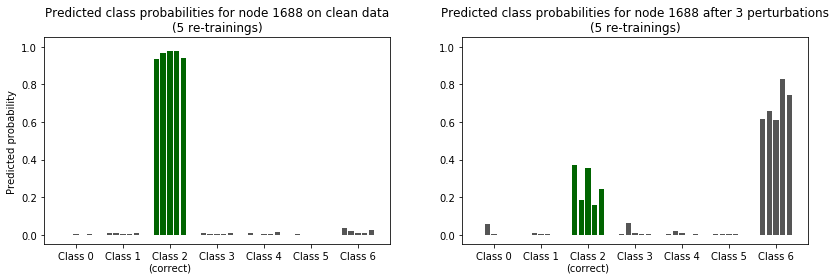

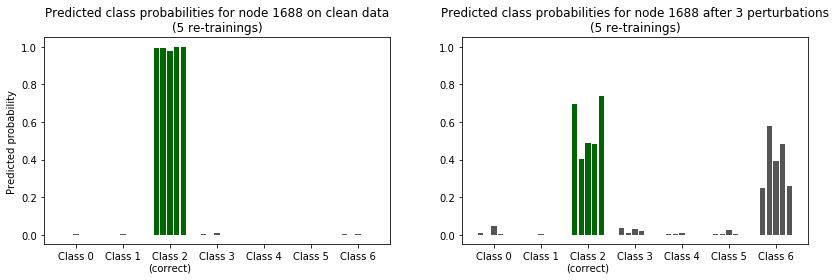

In [24]:
plot(class_distrs_clean_1, class_distrs_retrain_1, retrain_iters, nettack_1.u, nettack_1.label_u, _K, n_perturbations_1)
plot(class_distrs_clean_2, class_distrs_retrain_2, retrain_iters, nettack_2.u, nettack_2.label_u, _K, n_perturbations_2)

In [25]:
#u_hat_2=random.choice(vertices[np.multiply(degrees_hat_2==deg,_z_obs==_z_obs[u])])
#n_perturbations=int(degrees_hat_2[u]/2)
#[clean, attacked]=test_nettack(_A_obs_hat_2, _X_obs_hat, _z_obs_hat, u,  n_perturbations, perturb_structure, perturb_features, direct_attack, n_influencers, 
#             split_train, split_val, split_unlabeled, verbose=True)

### Experiments

In [ ]:
indices= _z_obs_hat==community[0]
attacked_nodes = _vertices[[indices[i]  and _degrees_hat[i]>1 and _degrees_hat_2[i]>1 for i in range(_N)]]
tot=len(attacked_nodes)


In [ ]:
 #DATA PREPROCESSING
#_An_1=_An_hat
#_An_2=_An_hat_2
_An_1 = utils.preprocess_graph(_A_obs_hat)
_An_2 = utils.preprocess_graph(_A_obs_hat_2)

In [ ]:
#surrogate model of SBM 1 - needed for nettack

if not train_1:
    surrogate_model_1 = GCN.GCN(sizes, _An_1, _X_obs_hat, with_relu=False, name="surrogate", gpu_id=gpu_id)
    surrogate_model_1.train(split_train, split_val, _Z_obs_hat, print_info=False)
    W1_1 =surrogate_model_1.W1.eval(session=surrogate_model_1.session)
    W2_1 =surrogate_model_1.W2.eval(session=surrogate_model_1.session)
    
    #Train GCN without perturbations
    gcn_before_1 = GCN.GCN(sizes, _An_1, _X_obs_hat, "gcn_orig", gpu_id=gpu_id)
    gcn_before_1.train(split_train, split_val, _Z_obs_hat, print_info=False)

if not train_2:
    #surrogate model of SBM 2 - needed for nettack
    surrogate_model_2 = GCN.GCN(sizes, _An_2, _X_obs_hat, with_relu=False, name="surrogate", gpu_id=gpu_id)
    surrogate_model_2.train(split_train, split_val, _Z_obs_hat, print_info=False)
    W1_2 =surrogate_model_2.W1.eval(session=surrogate_model_2.session)
    W2_2 =surrogate_model_2.W2.eval(session=surrogate_model_2.session)
    
    #Train GCN without perturbations
    gcn_before_2 = GCN.GCN(sizes, _An_2, _X_obs_hat, "gcn_orig", gpu_id=gpu_id)
    gcn_before_2.train(split_train, split_val, _Z_obs_hat, print_info=False)

    

In [ ]:
stamp=False
correct=0
mod_correct=0
mod_mis=0
mis=0
succ_att=0
mod_succ_att=0
i=0
limit=500

if strong:
    print("More edges within communities\n")
else:
    print("More edges between communities\n")


for u in attacked_nodes:  
    if i ==limit:
        break
    if stamp:
        print("Iteration:",i,"/", tot)
    i+=1
    
    ###### AVERAGE COMMUNITIES ########
    n_perturbations=int(_degrees_hat[u]/2)
    if stamp:
        print("Testing nettack on the clean random graph (", n_perturbations, "perturbations)")
        print("Attacked node:",u,", class:",_z_obs_hat[u],", neighbors:", neighbors_hat[u], "with class", _z_obs_hat[neighbors_hat[u]])
    
    
    clean_1 = gcn_before_1.predictions.eval(session=gcn_before_1.session,feed_dict={gcn_before_1.node_ids: [u]})[0]
       #[clean_1, attacked_1]=test_nettack(_A_obs_hat, _X_obs_hat, _z_obs_hat, u,  n_perturbations, perturb_structure, perturb_features, direct_attack, n_influencers, 
    #         split_train, split_val, split_unlabeled, verbose=False, plot=False)
    
    #if(np.argmax(np.sum(clean_1,axis=1))==_z_obs_hat[u]):
    if(np.argmax(clean_1)==_z_obs_hat[u]):
        correct+=1
        print("Iteration:",i,"/", tot)
        #Set up nettack 
        #NOTE: W1_1 and W_2 are the same for all the attacks and are computed in the previous step
        nettack_1 = ntk.Nettack(_A_obs_hat, _X_obs_hat, _z_obs_hat, W1_1, W2_1, u,verbose=False)
        #Poison the data
        nettack_1.reset()
        nettack_1.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, 
                               perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)
        gcn_retrain_1 = GCN.GCN(sizes, nettack_1.adj_preprocessed, nettack_1.X_obs.tocsr(), 
                                "gcn_retrain", gpu_id=gpu_id)
        gcn_retrain_1.train(split_train, split_val, _Z_obs_hat, print_info=False)
        attacked_1 = gcn_retrain_1.predictions.eval(session=gcn_retrain_1.session,
                                                    feed_dict={gcn_retrain_1.node_ids: [nettack_1.u]})[0]
        #if(np.argmax(np.sum(attacked_1,axis=1))!=_z_obs_hat[u]):
        if(np.argmax(attacked_1)!=_z_obs_hat[u]):
            succ_att+=1
    else:
        mis+=1
            
    if stamp:
        if(np.argmax(clean_1)==_z_obs_hat[u]):
            print("Correct classified")
            if(np.argmax(attacked_1)!=_z_obs_hat[u]):
                print("Successful attack\n")
            else:
                print("Unsuccessful attack\n")
        else:
            print("Misclassified")
        
            
    ######## MODIFIED COMMUNITIES ##########
    n_perturbations=int(_degrees_hat_2[u]/2)
    if stamp:
        print("Testing nettack on the modified random graph (", n_perturbations, "perturbations)")
        print("Attacked node:",u, ", class:",_z_obs_hat[u],", neighbors:", neighbors_hat_2[u], "with class",_z_obs_hat[neighbors_hat_2[u]])

    clean_2 = gcn_before_2.predictions.eval(session=gcn_before_2.session,feed_dict={gcn_before_2.node_ids: [u]})[0]
    
    #if(np.argmax(np.sum(clean_2,axis=1))==_z_obs_hat[u]):
    if(np.argmax(clean_2)==_z_obs_hat[u]):
        mod_correct+=1
        
        #Set up nettack 
        #NOTE: W1_1 and W_2 are the same for all the attacks and are computed in the previous step
        nettack_2 = ntk.Nettack(_A_obs_hat_2, _X_obs_hat, _z_obs_hat, W1_2, W2_2, u, verbose=False)
        #Poison the data
        nettack_2.reset()
        nettack_2.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, 
                                   perturb_features=perturb_features, direct=direct_attack, 
                                   n_influencers=n_influencers)
    
        gcn_retrain_2 = GCN.GCN(sizes, nettack_2.adj_preprocessed, nettack_2.X_obs.tocsr(), "gcn_retrain", 
                                gpu_id=gpu_id)
        gcn_retrain_2.train(split_train, split_val, _Z_obs_hat, print_info=False)
        attacked_2 = gcn_retrain_2.predictions.eval(session=gcn_retrain_2.session,
                                                feed_dict={gcn_retrain_2.node_ids: [nettack_2.u]})[0]
        #if(np.argmax(np.sum(attacked_2,axis=1))!=_z_obs_hat[u]):
        if(np.argmax(attacked_2)!=_z_obs_hat[u]):
            mod_succ_att+=1
    else:
        mod_mis+=1
    
    if stamp:
        if(np.argmax(clean_2)==_z_obs_hat[u]):
            print("Correct classified")
            if(np.argmax(attacked_2)!=_z_obs_hat[u]):
                print("Successful attack\n")
            else:
                print("Unsuccessful attack\n")
        else:
            print("Misclassified")
        
        
    
print("# of correct classified nodes:",correct)
print("# of correct classified nodes in the second graph", mod_correct)
print("# of successful attacks ", succ_att)
print("# of successful attacks in the second graph", mod_succ_att)

In [ ]:
print("#### CASE N =", n, ", n_perturbations=degree/2, strong=", strong, " ####" )
print("# of tested nodes:", tot)
print("# of correct classified nodes in the first dataset:",correct, ", accuracy:", correct/tot)
print("# of correct classified nodes in the second dataset:", mod_correct, ", accuracy:", mod_correct/tot)
print("# of successful attacks in the first dataset:", succ_att, ", accuracy:", succ_att/correct)
print("# of successful attacks in the second dataset:", mod_succ_att, ", accuracy:", mod_succ_att/mod_correct)

In [ ]:
name="Experiment"+str(3)
f=open(name,"w+")
f.write("#### CASE N="+ str(n)+ ", n_perturbations=degree/2, strong=" + str(strong)+ " on " +dataset+" ####\n" )
f.write("# of tested nodes:"+str(tot)+ "\n")
f.write("# of correct classified nodes in the first dataset:"+str(correct)+ ", accuracy:"+str(correct/tot)+ "\n")
f.write("# of correct classified nodes in the second dataset:"+str(mod_correct)+ ", accuracy:"+str(mod_correct/tot)+ "\n")
f.write("# of successful attacks in the first dataset:" +str(succ_att)+ ", accuracy:"+ str(succ_att/correct)+ "\n")
f.write("# of successful attacks in the second dataset:"+str(mod_succ_att)+ ", accuracy:" + str(mod_succ_att/mod_correct)+ "\n")
f.close()